In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.applications import DenseNet201
from keras.applications import MobileNetV2
from keras.applications import ResNet50

Using TensorFlow backend.


In [3]:
disease_types = ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '../input/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
16007,Tomato_healthy/55bcfcce-70f4-4634-8107-0a8207d...,9,Tomato_healthy
16008,Tomato_healthy/81024038-40ff-40c4-b8f4-4a48b08...,9,Tomato_healthy
16009,Tomato_healthy/058ade43-2361-4039-bbe5-0ac6618...,9,Tomato_healthy
16010,Tomato_healthy/2e485f1d-5aa5-4d56-8733-9625ed4...,9,Tomato_healthy
16011,Tomato_healthy/d984f436-1fde-4221-9563-82f55a4...,9,Tomato_healthy


In [5]:
train.sample(10)

,File,DiseaseID,Disease Type
5312,Tomato_Leaf_Mold/91a2c537-6b7c-463a-b59e-0f8b3...,3,Tomato_Leaf_Mold
5143,Tomato_Leaf_Mold/780aabe7-0d54-4849-80b8-77355...,3,Tomato_Leaf_Mold
7189,Tomato_Septoria_leaf_spot/b09cc616-1774-4fd0-8...,4,Tomato_Septoria_leaf_spot
5088,Tomato_Leaf_Mold/29059c14-7b1c-4e06-8c40-2fc73...,3,Tomato_Leaf_Mold
15137,Tomato_healthy/1352e7ea-9a81-44fb-98e9-25ee6c7...,9,Tomato_healthy
5194,Tomato_Leaf_Mold/80b652e5-7f1f-4806-8d9d-550ce...,3,Tomato_Leaf_Mold
1686,Tomato_Bacterial_spot/4d33be8c-151b-4d2b-960f-...,0,Tomato_Bacterial_spot
4013,Tomato_Late_blight/02fe963e-7c68-4fd3-9f8f-36b...,2,Tomato_Late_blight
10607,Tomato__Target_Spot/a1002a3f-916c-4c96-bdd6-8f...,6,Tomato__Target_Spot
6516,Tomato_Septoria_leaf_spot/a118d49a-e8aa-43cd-a...,4,Tomato_Septoria_leaf_spot


In [6]:
train.head(10)

,File,DiseaseID,Disease Type
0,Tomato_Bacterial_spot/a129e8eb-e2b4-4a8a-a509-...,0,Tomato_Bacterial_spot
1,Tomato_Bacterial_spot/21833eb1-b84e-4471-816b-...,0,Tomato_Bacterial_spot
2,Tomato_Bacterial_spot/67c8bbdb-ba79-4c64-897f-...,0,Tomato_Bacterial_spot
3,Tomato_Bacterial_spot/79d8d47a-c8c9-450d-a567-...,0,Tomato_Bacterial_spot
4,Tomato_Bacterial_spot/4436edf6-8c6d-4cc5-b973-...,0,Tomato_Bacterial_spot
5,Tomato_Bacterial_spot/68a2eeb4-4fbd-43bc-ba7f-...,0,Tomato_Bacterial_spot
6,Tomato_Bacterial_spot/6d672985-36f0-48ad-b956-...,0,Tomato_Bacterial_spot
7,Tomato_Bacterial_spot/47d90e2b-bd1b-4b84-94dd-...,0,Tomato_Bacterial_spot
8,Tomato_Bacterial_spot/c9c0a326-c094-4cea-94cb-...,0,Tomato_Bacterial_spot
9,Tomato_Bacterial_spot/5065cba2-6f5c-44e9-886d-...,0,Tomato_Bacterial_spot


In [7]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/67549f03-2c86-44b7-9730-32d4a23...,9,Tomato_healthy
1,Tomato_Septoria_leaf_spot/6c4377ee-cf37-4ca9-a...,4,Tomato_Septoria_leaf_spot
2,Tomato__Target_Spot/34edeb32-db7b-4885-b55f-5a...,6,Tomato__Target_Spot
3,Tomato_Septoria_leaf_spot/eb02f238-fac6-434a-8...,4,Tomato_Septoria_leaf_spot
4,Tomato_Spider_mites_Two_spotted_spider_mite/41...,5,Tomato_Spider_mites_Two_spotted_spider_mite


Setting a random seed is useful when you want to ensure reproducibility. If you use the same seed value, you'll get the same random order every time you run the code, which can be beneficial for debugging, testing, or when you want others to obtain the same results.

If we just split data without shuffling, it will give good performance on the training dataset but poor performance on testing. For that, we need to do shuffling of data. So, if we use random_state then we can avoid this problem. When we split data, we want consistence in the result of the dataset every time.

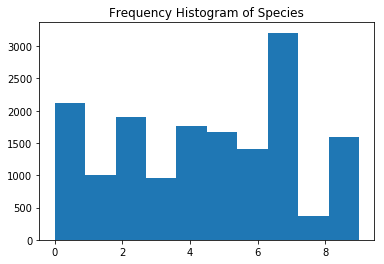

<Figure size 864x864 with 0 Axes>

In [8]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

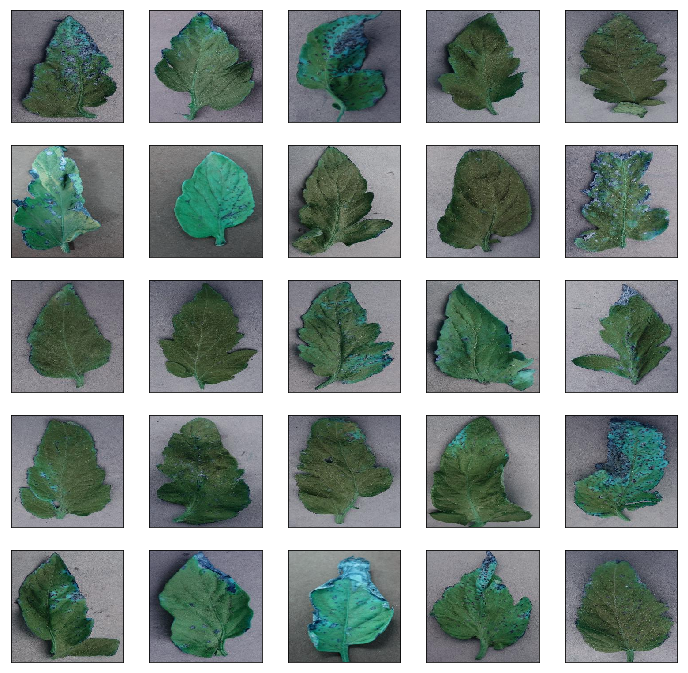

In [9]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [10]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

16012it [01:27, 183.17it/s]


Train Shape: (16012, 64, 64, 3)


In [12]:
# import cv2

# def apply_histogram_equalization(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
#     return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [13]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In summary, using .values converts a Pandas Series to a NumPy array, and this can be beneficial when working with certain machine learning libraries or numerical operations.

In [14]:
BATCH_SIZE = 64

# train 70 , val 20, test 10

# Split the train,test validation sets 
X_train, X_temp, Y_train, Y_temp = train_test_split(X_Train, Y_train, test_size=0.3, random_state=SEED)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=1/3, random_state = SEED)

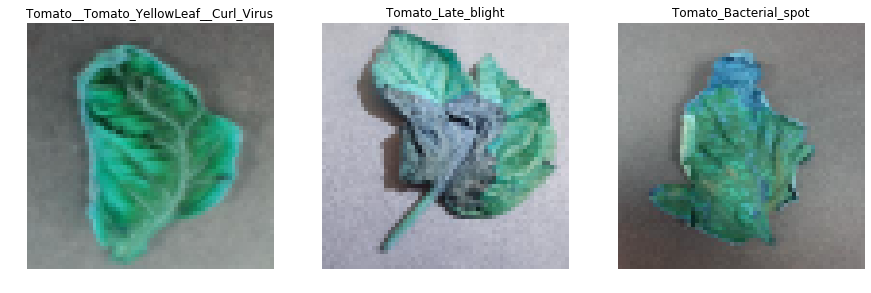

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [16]:
EPOCHS = 50
SIZE=64
N_ch=3

In [17]:
def build_densenet():
    densenet = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [18]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

74842112/74836368 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet201 (Model)          multiple                  18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
____________________________________________________________

In [19]:
model = load_model('/kaggle/working/model.h5')
print(model.summary())
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet201 (Model)          multiple                  18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9835

In [20]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# # Assuming you have predictions for validation data
# Y_val_pred = model.predict(X_val)

# # Convert one-hot encoded labels to class labels
# Y_val_labels = np.argmax(Y_val, axis=1)
# Y_val_pred_labels = np.argmax(Y_val_pred, axis=1)

# # Calculate accuracy
# accuracy = accuracy_score(Y_val_labels, Y_val_pred_labels)
# print('Accuracy: {}'.format(accuracy))

# # Calculate precision, recall, and F1-score
# precision = precision_score(Y_val_labels, Y_val_pred_labels, average='weighted')
# recall = recall_score(Y_val_labels, Y_val_pred_labels, average='weighted')
# f1 = f1_score(Y_val_labels, Y_val_pred_labels, average='weighted')

# print('Precision: {}, Recall: {}, F1 Score: {}'.format(precision, recall, f1))

# # Print classification report
# class_report = classification_report(Y_val_labels, Y_val_pred_labels, target_names=disease_types)
# print('Classification Report:\n', class_report)


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Assuming model.predict returns the predicted labels for your test data
Y_pred_test = model.predict(X_test)

# Convert predictions to binary labels
Y_pred_test_classes = np.argmax(Y_pred_test, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Assuming you have predictions for validation data
Y_val_pred = model.predict(X_val)

# Convert one-hot encoded labels to class labels
Y_val_labels = np.argmax(Y_val, axis=1)
Y_val_pred_labels = np.argmax(Y_val_pred, axis=1)

# Calculate additional metrics
accuracy_test = accuracy_score(Y_test_classes, Y_pred_test_classes)
precision_test = precision_score(Y_test_classes, Y_pred_test_classes, average='weighted')
recall_test = recall_score(Y_test_classes, Y_pred_test_classes, average='weighted')
f1_test = f1_score(Y_test_classes, Y_pred_test_classes, average='weighted')
# roc_auc_test = roc_auc_score(Y_test_classes, Y_pred_test_classes, multi_class='ovr')
confusion_matrix_test = confusion_matrix(Y_test_classes, Y_pred_test_classes)

# Print final metrics
print('Final Loss: {}, Final Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}'
      .format(final_loss, final_accuracy, precision_test, recall_test, f1_test))
#               , roc_auc_test))

# Print Confusion Matrix
# print('\nConfusion Matrix:\n', confusion_matrix_test)

# Print classification report
class_report_train = classification_report(Y_val_labels, Y_val_pred_labels, target_names=disease_types)
print('\n\nClassification Report for Training Dataset:\n', class_report_train)

class_report_test = classification_report(Y_pred_test_classes, Y_test_classes, target_names=disease_types)
print('\n\nClassification Report for Testing Dataset:\n', class_report_test)

with open('/kaggle/working/classification_report_train.txt', 'w') as file:
    file.write(class_report_train)

with open('/kaggle/working/classification_report_test.txt', 'w') as file:
    file.write(class_report_test)

Final Loss: 0.07200151150359735, Final Accuracy: 0.9750156402587891, Precision: 0.9754298072571806, Recall: 0.9750156152404748, F1 Score: 0.9750509794960741


Classification Report for Training Dataset:
                                              precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.99      0.96      0.97       217
                        Tomato_Early_blight       0.97      0.99      0.98        97
                         Tomato_Late_blight       0.99      0.98      0.98       164
                           Tomato_Leaf_Mold       1.00      1.00      1.00       101
                  Tomato_Septoria_leaf_spot       0.99      0.98      0.99       198
Tomato_Spider_mites_Two_spotted_spider_mite       0.98      0.99      0.99       163
                        Tomato__Target_Spot       0.92      0.96      0.94       139
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      0.99      1.00       323
                Tomato__Tomato

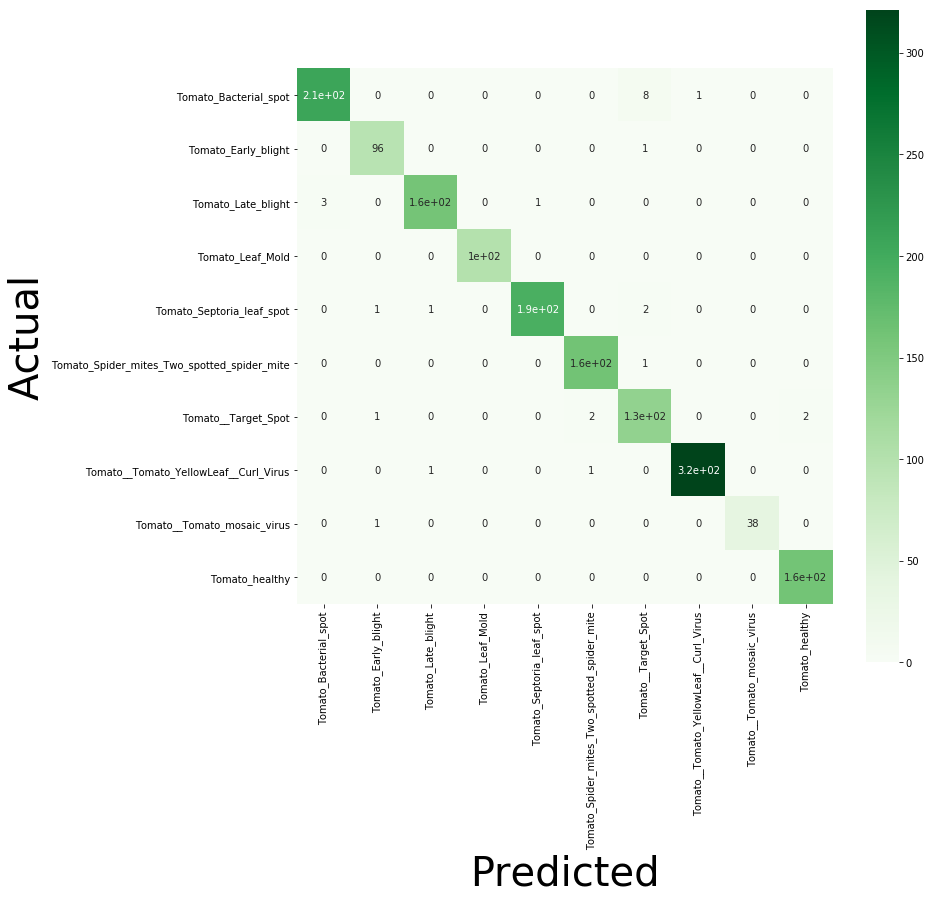

In [22]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

plt.savefig('/kaggle/working/confusion_matrix.png')

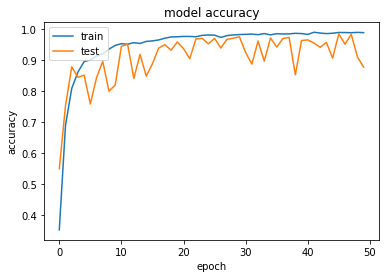

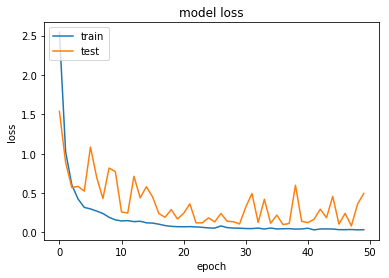

In [23]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/kaggle/working/accuracy_plot.png') 
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/kaggle/working/loss_plot.png') 
plt.show()

# Testing Disease Prediction

[8.5608110e-13 6.5164073e-05 1.3305220e-07 1.1006446e-07 5.4011065e-07
 8.7058599e-10 1.4872505e-05 3.5247621e-12 9.9852484e-01 1.3896400e-03
 7.8373375e-07 6.3981736e-07 7.0488062e-07 1.9266367e-06 6.6465225e-07]


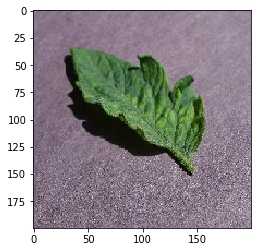

Prediction: Tomato__Tomato_mosaic_virus


In [29]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_mosaic_virus/021accd9-bbb2-4777-8f94-93295e6de49e___PSU_CG 2075.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_mosaic_virus/021accd9-bbb2-4777-8f94-93295e6de49e___PSU_CG 2075.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.savefig('/kaggle/working/prediction_plot.png')
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [25]:
# import urllib.request

# # Set the figure size for the plot
# plt.figure(figsize=(15, 15))

# # Load the trained model
# # model = load_model('/kaggle/working/my_model.h5')

# # Define the image URL
# img_url = "https://www.google.com/imgres?imgurl=https%3A%2F%2Fdoorcountypulse.com%2Fwp-content%2Fuploads%2F2017%2F02%2FEarly-blight.jpg&tbnid=OkaWKnZbFZDOpM&vet=12ahUKEwicpIyAgJyDAxXme2wGHfUrAYwQMygRegQIARBk..i&imgrefurl=https%3A%2F%2Fdoorcountypulse.com%2Fpest-profile-septoria-leaf-spot-early-blight-tomatoes%2F&docid=lj3g3J2UvP1WiM&w=780&h=519&q=tomato%20leaf%20disease%20images%20namely&hl=en&ved=2ahUKEwicpIyAgJyDAxXme2wGHfUrAYwQMygRegQIARBk"

# # Download the image and save it to a file
# filename, headers = urllib.request.urlretrieve(img_url)
# img_path = os.path.join(os.getcwd(), filename)

# try:
#     # Load and preprocess the image
#     img = image.load_img(img_path, target_size=(224, 224))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     # Perform further processing as needed
#     # ...
# except Exception as e:
#     print(f"Error loading the image: {e}")


# # # Load and preprocess the image
# # img = image.load_img(img_path, target_size=(224, 224))
# # img = image.img_to_array(img)
# # img = np.expand_dims(img, axis=0)

# # Predict the class probabilities
# probs = model.predict(img)[0]

# # Get the predicted class index and name
# pred_class_prob = np.argmax(probs)
# pred_class_name = disease_types[pred_class_prob]

# # Print the predicted class name and probability
# print(f'Predicted class: {pred_class_name}')
# print(f'Probability: {probs[pred_class_prob]}')

# # Display the image with the predicted class and probability
# plt.imshow(img[0]/255.)
# plt.axis('off')
# plt.text(10, 20, f'Predicted class: {pred_class_name}\nProbability: {probs[pred_class_prob]:.2f}', fontsize=20, color='red', bbox=dict(facecolor='white', alpha=0.8))
# plt.show()

In [26]:
# # Load the trained model (uncomment and provide the correct path)
# # model = load_model('/kaggle/working/model.h5')

# # Define the image URL (replace with a direct image URL)
# # img_url = "https://www.google.com/imgres?imgurl=https%3A%2F%2Fdoorcountypulse.com%2Fwp-content%2Fuploads%2F2017%2F02%2FEarly-blight.jpg&tbnid=OkaWKnZbFZDOpM&vet=12ahUKEwicpIyAgJyDAxXme2wGHfUrAYwQMygRegQIARBk..i&imgrefurl=https%3A%2F%2Fdoorcountypulse.com%2Fpest-profile-septoria-leaf-spot-early-blight-tomatoes%2F&docid=lj3g3J2UvP1WiM&w=780&h=519&q=tomato%20leaf%20disease%20images%20namely&hl=en&ved=2ahUKEwicpIyAgJyDAxXme2wGHfUrAYwQMygRegQIARBk"
# # img_url = "https://doorcountypulse.com/wp-content/uploads/2017/02/Early-blight.jpg"

# img_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoGCBUVExcTFRUYGBcZGhwcGhoZGxwgJBwhHx0cHyMgISAcHysjHx0oIBshJDUkKSwuMjIyGiE3PDcxOysxMi4BCwsLDw4PHRERHS4oISgxMTMxLjExMTExMTExMTExMTExMS4xMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIALkBEAMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAFBgMEBwIBAAj/xAA/EAACAQIEAwYCCAMIAwEBAAABAhEDIQAEEjEFQVEGEyJhcYEykQcUI0JSobHRYsHwFTM0coKy4fFDc8KSNf/EABkBAAMBAQEAAAAAAAAAAAAAAAECAwQABf/EACwRAAICAgIBAwQBAwUAAAAAAAECABEDIRIxQSJRYQQTMnGRocHwFDNCgbH/2gAMAwEAAhEDEQA/AOuN9nTdlsPLAThmSL1hRk6SfFjQ8xSqMFKuqNzm4wsZ9e6q/aFSZkMki4x5iORuQbGAY78Dyq06cKI02GEn6ROKKrd2TDkz7YLZvtZ3OXQmnrqMJE7AcicIHH3bM1mrusauQ5RhsKnnyPUDGtQnwPjsWJt54qcXRKpNRIJ5jAXJcKrVG0U0ZiN4/fbDx2c7G1lio4U/wEmB5kjf0xoegbuctxTy3CqlYzSSOTapCn3iJwVp9iySpKESblSLftJxpa5OmtPUV8VNtJHlPIdPMYIZKpTI1qwYAWM3HkR++BZOxCGI1Fvstw+lkaTl7vUA8DwAY6eeJuPZUVx9tJTZUU29+W3MYJ8Wpd4NOkat1PL2HUb+2B+aouF8Qvpg2sDFm98URB3UR3Y+Zl3bTsucvXIpy1Nj4PKbgT+WPuE9mpPjXURczt+W5xoFCnSei1Sp4m7whQTcRuT5Wxep5dIBmFkEnoBhmLXXiT5MRK3CuGLQpLTA01XClyYEcwoHIDn1IwWXhFDMN9smsKJWSQOQ5ESLD5YGrWFWuNIPhJN/Pa/KcX3zYpuArang623A/hAkQBhVYMNTgKM+q5elk5FKmqa2UBV3Y9N7wt8D+1OWLrSqhA2moA6ECSpUht+hgx5YMZeutQ+LuyeQYEMvuD+mFTtP2jRMx3bLoCrdZv0mCf8AnAdTyDXKXqX37P0aqxpS8AQNvcXm2FbifY7ujrpszxfSRNvUb4c8jWpd19YDAU+dQGNJ2v0wWpsDRPiBJFnEXG1uU4gcjo2uvacFmV0siz20zivX4O4N1IGG3jmVOXHeo3xNGkj8x8sCP7SqkxAM2iOuLq5amEtjUXcTuL5RgyqqksTAAEknyAwLrKyMVYEEWINiPbGv5TKr3wcIpKD4jO5HLoQZ5Yzrtx3f1uqEGxEx+LSJ/PFkzB9QMwZtQMMyQpjFM0qhvJODnZ7hgqv4thy64cM/wWmEGlQBGCzhehAHAmc8NqVKbhgSIxqeXrA5daqCSwjCJn8qQYEG8CMP2UyhTL06WxAv79MSc8iIG3uA6OUOrWznWDNsSNTqhzWXSWidsEctwXmXMYKFqdMGBNrkxAwGBklO4rUiahZqhMzifhOXTv0MEkTc4G8S7QsahCABQY2388T8C4zU79FtpYwZAweJVaqH/lcGZXgTZjPupJ7tSWeCdhy9zjR/7NpsCrguoChNPhUQbeo5XOKvBGQZhhpBL7QQLgE894I2xe4lmmePhVXj4ZNz1npvjhZNe0oxsXAg4czeOBoV9MWuRuLHlIvgnQyg7sypg7HqRGw998F6dGmiAFgOUESYjcjFenRZtjCn8+kfLFi2tyJUeJ3WreFWgyQPTzwk8X4wVrsjRUSZ0ndfQ4H9qe0zZoImXNRAs7GNQIHLywpPnnBIJMzed8ZMeAEEnuV9XiaNnqi1EV1+GAojlHI4tcKoZaPtjUVQQfBp256pEx6Xwldle0PdNoqXptvP88HO1vD6z0jUyza6REsi7j9xiJUqwVtfPvH4E7G5o/Ba2Qd9FKogJgqkaT/pkCfzwczFRUbTed7kW9hc4yz6GMrUrM5qLNKlBRmF1a9hg79IfbQUHCUoaoLeg9ccGVX4Ab/mOcfpsQ5x7PeBU0nU7i+krZee8m8fPHFXJIQNLNTcqYK2gjf8j+eAfC+MHNCnWVrCxB3DfeTa8bz6YPZLMUywpsSCBBBNxO+++24xejdzMx8GWBnWWDNNrCQqSxt5f9Yl/tAlSXpqF6HePO8DFMOqwBJJBW28Wi8YX+1XE1ogJU8OoW3vETf3GLruLZhWkmVqEkI3n3ZkE7fe3OKIylAZi9abWpVGOgGeoty2OFTN9slCslIQSpXWZBAO+kcvXCxQzWswztv1wpxkxgfcTVuLZoUrlYLC7KBB5WItYYAVOLFSG75481V56zPiwL4PxmpSU03Pe0jvTe9vI9cdcT4OtRPrGTc1KQu9I3en77sv5jCKvE11/ecVvYjLluMUyQwqUmUXJDqpnoEJke8YX+3uVFd2roFdYUErdlgbuB+othbqgG5X98Gew+Qq1Myq0p0/+Sfh0HfV5Rywx0LJirs0IL7O9os1lnCUwKi3XuyJ1/wnr8sadTqqpK06YCiPCxLBTF1XooJ2H/XeQymTyZc0EVqs/GxnTbZeajlgZWztOhRbM1LhDKj8TfdHufYb4gciswAEq4IFXD3GOEVKsrpkAWuLeg9cLByD0qg1KwINvCd+W/nha7LcfqPUK1HYmox2J8JYyCPTDtSztdFcu7IAIUs0qTO41eWGUlbWtS6OFXcl4zVqZHJ96UBqMQFJv4jza4xj2eUu2q7OzTtdifIc8bjmqVPN0AKgUgQeomx/0+uBfZrs4mTFSqaeqqx8DGDoUclOwnrvjsbBAakbEz7h+UzFKH7mqBz8DftgtxTjE01VQSxGHEZoC9RrmfCtyfKxsPPFKvk6dVCaaaanIkR7bRjjksipOwfyijwDhOlxmK3wgyFJ5+mGHN8YpAF2qADphZz1YqzKzSFJm9pHTCpns21U6dlxVFN8jD+WvEds12yoAwpZsAuJcZrVzpU6UPJennhWzOXKG+2DnZijKFztMewxQgKLEpxULcs5bLi0wo/E2DXC81ldQVEYMPvsALxuL88VlIa20cuuCOX4epGoxFvPCOzCjIAz3h2aqNmUAUsSYiBPqOWHqougkgAaAAwaAQfLSY254U+zufVMyyssgoVXlFxceeGYlXrMGEAQscySJvzi+OBJMYfjPsuW1irUCsrA6ZvvuSCN+hwQyX2lXSABAt5W/Xpgbm6umEVFB0jSFMyQPywT7M0wuoneAST1MYa7g8zL+wXD111Kb/3lNvmDcYr/AEl8JSm9OtTAHeAhgBzF5x2nElGfpmk8d4vduRtI+Hf5Y77R1aubrLT0FEp7Tv5k4zryGTkfMsdbiWtInDB2V7Q1Mmwk6qfNenphqyXZGiaUGS0fFO2ETjPDmpVXpsCQpsYMH3xVuGUFWhVyDqfoXh+aptkjmKQADUywgReDv5zj86Z/Ol6jO92JMk42f6Icx3nCmRjZDUUz0kn9MKHZ/sPorjMVWV6YZmFODfeJnljFgZcTsD2NfuWc3Vz36MqdRadQuumk5DA3JJjTZAZKn8XkMOveI+iFDVFNjBBIG4GoyRvacU2zCuV1Ko0kLYHwgbCQBzO2OqlAIZYMD11Hl943tz28sXVi3qOpjyH1ahzLOC6E/cBsPOw/TAbtfkBmcrUU0y1QHXSKmPG3hA/y3vNhAwT4TmZUqYJC2dYkjzgb+mJqVVV1kMEVVEu3K3K92w33ADd7i0RMRzvCa1ME1KTKsxPIH1BwN2Nsatwvhj1CxdyKTFtJK3qIb6vIbCTuTgnluzORoEP3Kuxv9pLHf8JOkGTsByxQ5xdeY4PkzKOGvUayozj+EEx8hg7lhWyjLX0tT1kxqtOmJEb8+Yw+vmS5hBpE2UQoAteBEDcnGa9sOL97WIRppUxpQ8m5s3udvIDDXz0YoO9Q/VyNHNkZiiQl/tqY68yo5E9NueGTguY7ui1DLU+7DTqc3M7Ak87wMBOyfBjSyBzFQhe9IeLyEAOkDzJM+kYF5rtRUCslJBTBBUPJLQeY5A4yFXe1U2BKE8TcuZLhzU6pJzVBW1Q9ySYO0FbEYl7U8LzFVIp6KlNmhQrgxzgLaTbCcjE3Mm9ycPXZjNAqUJ8Qjuw1heSxn8VsWOMr6hVj4i8x1KXYnICnQYPS01tbAsykOsQIBItYfng//ZrOpZhYDwixgfoTzOClHOHwgkEEAw39W9sT1aiVFAXw+RFp8oOFU2bPmK49ov1cjUp1FqLTZ20kEEwOknT+lsFuG5utZRSIBiUe4PmD1jHOZNVCqLpk9Pnb9MS0gjU2apU1ODA0yIjks3Pr1wxQg6ihqk9bK0nVigKNBlTuBzidxhW4xl2TWUDOCsgrM/LBuvpB1osm2o6pI6898Rh9ZLpIqMLcgw5gjk364TgA1iMGB1Ml4g+usifdO+LGYyAp20j164540g+u1GQFRzVgRpbmL/1fBItrpBG3AlTijkgipQkVFjiKg2xPw/NulPQu2q1tsQ5kEEziThw8V9hjSBqKTqFMpYyxucG8tWamsSCJ2wGpkAyR6Ynoub6toth+IIqRuHOB5RKmco6tiSWAm4ANrXuYGGvOOiVGD0wDFjY6RyEi8+vPCZ2Xz/2yOFLEyoA3vYbecYae0VFRUpCwH3hJ5XNzF5xmf0mpVdrI8u2moKrWtYDl/wAnDBklii1QwNRt7D9yMJHEM741AhQeUzubn1OHjPVlXK0yCCCsfzwA2jOmLZbgGZqAtTpPK+JSQRcXm/phyyvDqlalSzNIT3q6qnVWFiPmNsE+xfHO/pPUqnxJYqB8gMBeCZw0KuZyssAHNWkOWl9x88R5O5NjYl2KhTPaXEawfQxKqLeZ/wCMS57jVGmrGoykhTCtBJ8oxR7a53RTpsxKksRI52v7YT6vCWrzUp1A7G8EwcHgDttSaAkzRvod4qa65ih3aIrfhBHxAxzwZ+tIKjUGdpHhLASB6XF8AfoOyFSmMyzoVMqPEI2BwGq8YFPidWnUYLT70EE8jb8sZAOWdlXrv/yaci+gGOfEs1SpIGYoEUgMzrt5+p98A37e5To5JIECnpIvclg0Ec9sR9uqyPlyodXZ2CrBmbzPtgPwfsYKoUEtJG4/qw88beSqKaYxXmOmTzmXUd+alOmbEBdRY+ZPhHsBj3tLmKZp96ZcOQaKBIAaAZJm0G8nlywKfs5Sp00pNmGYqpgKoYAzIBMyYnmB5YJ9lsiyF6LgvTHiWo9kDiCukHcdbcjOMeRkuwY6AmxCtCmxJfZTGkGBYXjTaBf8sQ1OI011qzqzLMohpFjuYA1Ezfy3wr1e1Gac9yADUkqw03LSRAjlHlhSzrPrqajFQMZI/ECZj3H5YbDgYdtOJBjT2i7YhXWmQ60ogoN1BG7GSWeTJGwA64o5PgtHM1aSo1KCw16HF0ufhkkNsOVicC6WXfOoaToxqKPDURCR6PAj3w1/Rz2bfKUaleqmmoTAU7gAkC3mTPpGLOSqaux4/ccKLuTfShxkIKeWp2A3A5Af1+uEui/uOmPYqZzNVWYBAphtViokgALcsT5YLZns6VK9zUWrIEqbGelrel5xTDxxqFJ33J5dmC2ToIB2xbUEAENEXsf54iD6ZVtxNjuI8sDOPZtkVFW0iW88aeXtJBSx1HHJdoIpsalKpUCCDUp3InbV788Hsq6sKenVpeDrEmNyCDEeXyxj/CuKVaNZa9OoUddiOfkRzU8wcaTwH6RaNXwZkvRcwAyXpzNjzKediPPCOntKHGYw18wVc6iTptY3NtwOmOckgYwC2g3BgefpfB2jxBigddLAybMrBhvYjw/n7Yqs9JtMrAUgeCwIYwZi0i9xzGJcR1cQieJlkZfs7lWg2E+k7g+XninmsnpYKEJY+IQb+UmIkRHzGJeH1AveU3BBLRPPb4xHUXnri/QqzGoaoJBIMGQYm14NjG2CqA6nVETt/wALqSmY0AALFRrSbjSbbmDvhbc+ExuBjVuLUadSm1GqAKezEyJi4hgJEGDbocIbdmHS1SopnbuwXnb0/PphykY9RK4gOfXHnDaigkHmMMmc7NK06KthYhlEq2wBGq0nCeLEg4op8ThsQ4XBETP8scrXIGmbXxS4Y4giZb9MS8yekYopkytGGuzmaNOvSYW01EM/6hh343xAOz1ElwRFhYXkn1jnjMstmvFEb4eK9T7FCBJheXKLx8oxn+oo0RHSwKgvOVjUdZIsdIFrC9rbjDJm80NIX7tMHbyOFHh1aa94AuY8h/1gq9UMxWY1SR5zzxnuqjV5ih2S40tCuAx8DkBvLocG/pDzSpUpVqc608LnkVN4/rrjOQcElzdUppJ1LEeK+NnHdrLFN3DHbjjIrmiqmQlPxf5jv8hhfy+YemQyMVI6YhLcscajg8RVRgKFTbPor4w+ZpNq+KmYI6yLHCh2o7O1audrMqhU1SXcgDbz3wb+gUQ2YvuEI/PEnFcnUzHGKdGqZozqZZgaQCTPWYj3x4iWn1bKhA15mhqKAmD+zHYt+9H2yMNM2DQAeYO3LbGj5HL06K92L2Bn0G5g8+nLCvx3j9HL1wtSoQGuvdqugAE2JmQbRiQ8eEipThiRZnJYL5AbX642FC22N3MWQm+qhl0AYOwC33eCY6C25PyHrj3O1T3VRoJWEAaTcmTt8/ngDVStUYs0+bNZfl09MX+IZ6m1EUhUEArsDuBFj74yZMaLTE7v+Icbd3B1bMigBmBT+1qxT1NMKRI28wJ84xL2S4QKYdqyIzGoWbVB5WPOAdRxFSU1NVGoWemRKt0O4udjHXEC8RzFQtolEGlBTUXJW12jUSABOOtqIU17n48AQkjRIjd9bqIAtOmqryX4Re9o5x1jFPiHGUoLqq1kprNxF552QMWwr5ltC98HL1EYDUTKwLPp9JifIjCd2jzjVKzqLwAfmJxpwcnNE/uIVs7mm5jN0aqLULCotRfCwVgSpsLm4vgXk27qoWpowSPCfCT7gDGf8M47Wy3gUq6Ag6XEgbbGZX2wVTtouolqTXP3XkL5gECTir4nLe8Q4/aNvGaH1pPChNVfEDIvFyP/AM/nhS4v2fqV210HSohOm8oVI+6dQifkMO/Y/iCV6FauutIhdbgCLTIhiOeEbM8SbLZyq9B0dXMspGpTN4ItcdRhsYKnj5jqvEQfl+x+cb/xaVkDWz01W5ixLeLrbFit2IzdMuxplwlwyQdYmJW8nzESMOXCe0WXzFOGKUKiyTqqaf8AUpMBhtY9MEMzn6isDKtpkSv+6NwR6bRh3zFO4ObRF7HcXZNVE13pJJJhdQB80PKd4vfDSKGZRi+tSrMGVgwCuATNrQZ5EDEXGqKVMvUrLpUrpqwAOfhYfNp9sV+zD/WKFTLPykjadLXMehE+oxmyurKXEKj1RgTMO+Yq/ZlDTpKuvVvBBBP3SpXYXsZx1X7W06bFaSFmAMktY33mJJHpi88rTFNaiU6aoF8YktAiSWMG0WjEVLurBRSMjxFQII6zHQbYRMlnkIzAAQbwjtClcxXqGnUn4TBSoCbfGpg8jHriemlNqeqnSAWdLKYsZ2PK4khhY+RGAv0hcFC0DmKKEsuktoNgnN4jba42wm0u1tdaDUPvTK1dRDLcGDyO0e53xtQEi5MJyFiPvaSqqEO1DRTGnVVptqIuPiQgEXgAy2M64xUR69R6YARmJULMesNcTvHnirm+N16p+1qM/rt8hAxD9YXfFlWowVgJx3ppuGHvg0pDLqVtxywFrAPiXJ1dFj8JwxnOvIa7hMIRN5w39l82Sppn7uxP4TuPY/rhUoOGgg2wf4eQjqwiOY8jviGQ2JMXcN8R4GpBZfCWBPuL36YpPlmp09bgLpIIM/P2ODRzQSlqd4hTqnaZwhdoOMNVcKCQmyjr5nzxIY7qMDcTkF8EszXXugoHvgcgxcrglRG2NomqVIvjunT64+Cc+mLJg3wpiEx++g6qRmKqzui29z++DP0i8MqfWqdaixLoy61QNKgmZNtjEW64AfQpH11x1pn9caVxWsO/LBzrRLqDebRq5FYx5LtjX6o2N0Ny9jgLmVfSVl6aZt3cs0gEJEBQRt88VOyuZohWqVKqIysBTpsTEWloAg3tc2g4ce1fDRnF+0MVVMCoBYg30wPM7+eBfBfozLl2qVkVd1ggm3OOnLGxWRlrlImn0IcoJ3ukGurl/hAYQfTcjzjEwSlSO3eNMRPwkD7xaR52k7Ac8BKr5Xh0mis1SIFQiSI9PhBwpUeO1Vq1KhhxUbUyuJBPUc1aOY/PGP8A0heyLrx4uDgF/c0J1q1Kyq6U1pEEHu3ut5DGd2BAsBeSMVcwe67xgTAB8pJEX6EEYh4bxGhVUaKsMwPgbkd4uLYsZumTTNOZmzANeTF2noLYzkMCFZai7gPI8RNV+57sBAkDn6zyvfAXtTm6aOKSySI1lSNukxvHPlglx/h1SlBp02F9AKFjJn7xB+IzYCBgDmuzWcWGfL1PFewmf/yTGPQw415cgdTlGty9mOzoq0BmMoWdfv0mvUQ8/hA1KPSfXCzUQzBGHLs1XzOUDr3NSHiCFMg8sUu13CagYZqxp1RqBC6SD95WXkwP642CwahE0TsgKacNSjMd4rsZgG+1tpAGM3zuSqNUd6aMy6yLCTPoLx7YNUKdSnkKEtd6rsYMwoEASNhbbFPh/HlFQrUEIWBFRd0YCNVtweY98QDMCxG9xWgRcq2qCrDyII/XD1wvidNUVaiOhAA1I02A87yY6nF+vXkAVAlVIDBoBsdiOgjngLx3JIF72k8AkeDeBe4JO1tsR+8uQhW1JEHuHVp0sxTfu5CwSyN8TabjyueQxVCGhT7pFAqVCGYxOhdwAeWKPZdD4qtRtNNf4oDH+YH64L8Q4nllBJcO7wGIGliCeXoBM+WIMvFyqix/S5VfxswNxOlm6tIhVZ3O3OB84X1x92NzeYpOaebXTTWQCw8WoQbfiWCQfXc4NUK471aay8rqUyIO4URtuI9sEqPdVyBUpeKLAmY8x0viivY4stCITU7aovgVIehVQ3WCIa8SeRDRFsZT214F9Vrwk908mnquRBAKk84kX6EY0F8gci7LH2bg7AAMJtI2DA4mzWWpZukyFlaPEuoXUz0O4IJBid8a8bUKiK3E/EyXg3DGr1lpKQCZJJmABubXPp54tdrOEplmpojs5ZCzEwB8RAAA9Jv1GHfJcFpUqorBQTSkyoMSBG3O5xS7YZGizd/UL28CqCBJF+nIk3xX7gjjL6h7RARMXctS1WjETUxJiYm3pgrwhAPG3LYYLNq453LK00pqoC4uJmRa0qOm+KlSoDc4C8VqkOGUkemIhSxuLx5dQxx/ibMNJawMwMCMlXmqp6XxWzNTVfHmReCTioWhUYLSzmtRVNIMkkA/PEgB0Fh8IME9Mfo7OcFpVQaNSnTamAukMoiBHlb2jHv9np417tQALNC+JR90j7wHntiA+pAHzH5T84Uqdp5YlGSqimKppt3Z2ePDuRc7CSOcY2HjnY3LZhWhBTqbq6eGVMXKr4SwnpjrszlHoZfuGUBqRelUB2a+oNHNWDKw3sThmzACwILFRb+hbLgZuTvob5Y0Tj9Kk1QEDx2Db3/DIHU4W+EZOnkatV6caqviWdqVMAEzz0BpPoAMO+Rp0xSmQ5eGLcyd58h0GPMz47yc7llpkqI3EeHPTvOxGxjboNwPI+2Jq/HEcadEMAxA8/vCeWwPvifilCWfQ02MkDUBuPFY3/bC1mqagyzjqGB39iZAnHMLAJ7Exm1NTnjvAFzLrVptBclWB+EkQAQR1IOOuDdgkY6qlVWAJBVQdx5k4npZnQEESRIB6g9D64u8LzTKCvwoCYPXrjh9Vk6EtjomjD2U4PksuoIRBpvqa8fyxX4ytOqBWpFamgnUUIsNJ3G7C+wk4XeMVAWD1H1Kvw0hPibqeuJ8tVrOvibTTF4tb0iOe2FYv+TGzGZ1vjUkNSpSpvopJUFQkENJEeQ5+kjcYqJlaQKFAyVR8S0yQo6AyDt7Yv0cyCxIqFmRdRiOYIjfyj3wOrtVZCFQKIIFOm3ia+xsb331YVOZNDX+e0UwrWr1dDWLlREB1Oo/hIMEf8jEr8RFRBQq5YBTeCIuDYzNm+fvhLyqLQJbu6yH8RUkTPoAb8/fDHwHtAwGlSjjyC/odojHoICo2CfkQKb8yv2wyFRaKOit3dMMpBj2PL+jjM1vfG61OMa6Wh48VmAgRGxtzwvnsDlagmnUZD53/T9sOufGnpYkGMUJ2IicD45VpQurXTX/AMbbEeRiQfy8sNOSrrm01BBSCsFN5JHUtAB32jpiNOyVGjVIq1Gfw6lCgqG3kSbyI2GLeQztB1amCyIPB3XdNeN9JG4II88QzkP/ALYs+4iqlHcp5yg70u4pKCuoBI+8qwWYtMASQvUnVaBOKFXgTMwYV0dgIVSCB0s1xMcsV+LcQqd8Gp/Zoo0qFtYNzHWfLDBw+tSrICwCVYAbcAkWmRYSL+uFvJjUV/37xWKkwZmqT0lVSpCg3YCRPXUOnTDLkuJLVC6wKZLDm3iJmRI+Enf2xWOUqpdPEOYNwfIm42xBUsCShQrPg3HqvWOnTDI/PvuQIqMSVdJK1EYobbyDNufznlgXXyEFFVfCSAC3L+R9sCKXFKimUYj3tfy2jEtHidS5LFlkagANzsR/xjQBx3BYM7y1OahRmY6CbHaN/Q+WB3axA1BdJ2qzHMLpYT84Hvg7TpgqYB1H32AB/rywF43UVaDqXRSQIUm8BpiRzth1EAOxEzMCLDFkvppX57YrN4jbEfFKs+EcsUmnueNmdhivmXnfECtjmq84eMF3PWfH1E4+prIxZoZU8wR0HXHQtQn6WzDtTeWaFaLnkQoB33B6WOKeWqMKjK1tUwvmNiJ8reeLVHL09YaNTciWn5EzI88QcQpkNcU6aC7M51T1CrG/njyVZgeJ/mcQDuRNKkBokREDe36HEWfZSKjAgN52uOR8wCRixWyqVqepSyDk5kX6gEzHy9MDeI8PqiSumodMSpg/JuceuKXEqCcymp1reEsKdSmxn4tTKVtH8L4vqgNGn9o6hVgqGjzuDzvhdzxYMikaPHJDSDYTEe354v5WtUNEs5ASNRMibnyEbWxM6AjYyeW5EucpUA4VLsSZN5Jtz39sdVqiFRqZUaBPeSd/KenLCrm+L06mcRN5ZRt54L9pUqOraELFhci3Pz3w7K1gHz5jZAG2ZZJpBSQwYTJvZQDdhFvQY8qZsNpDTTUg6f3P74G0MmEy9Og9TU5hmgzBJkjzAFvniDtW4pCk63JJDTsRAhT0NjiX2l5cV794ivTVCbcPeoyjvCAL6l/DzHrjrtFmyBopozNYBVBPlyFvM454TW7vL944YBvEobciLL/3iMsvd94pOp+cgx5Wi2JEsG9WwJQgdy9whu7pSzK3iI0qNzAJBgnUb/IYs1J+KmVCnkVU7i4Ekf1GA3CM99pSoaFgB9R+8SAx6WuAOeL1FyqaiZUgbRYz77A74r9oM1mZ2cynxOu1NWZlraR8TmyesIQSPmMVCKdTxvSEkDx02ZYEb2N/Ug4J5syCCQbERIAM9RsRgTw/OU6M0ahApsZUqW8FoKkETom46Y0AGqXUSwZZyVEA6qVWoD0qQwn1EGOe2LeW49UpECoq+KYK3AAN+hm4jHmY4c1mSIIGmDM+dsV3pkq1NxIYQREHff1B54kcxBpxYlFJ8QzxLNrWFKspHgIBAuwJsbC2159ccDMLUbQigUzOu0M/SIiDfnfFLg9MIxAWASOZOwJm/n+uK/GKjVayCie7NM6atRCdO2xQ+HULXthceQK5KnX9JUWRvuWuIZKjV1lKTpUUSC3wmN+W/villqJUAtZBck7n/jBgLTWlAKFx8bkRPksXn2jfFfM06dVO6d6dT8PgewJ6iP0wxz8hv+YpRblLvysNTkA/xGPkLYhPEKlx4z5deWKDcGqUg4TUUBPiVw4EnmN4/bEKCsAH1Wj8Qn3AxoxqtaIkXXct1E1GNJBi4a0eh5YuZBGWzC4YHcE36xY3AwJydTxTUlxzvgtlKaiU1C4tJ5AGNpMxh8l6UxFWFKTszWJA5dI/WcJHbivpq90IIEMTMmTO/T0wxZ3i9KiB3hYlh8K3PrJMe4wofUDWqM+nQhM7yfz5nFEB7MfGK2ZTyjkCTiHMUnIL6TA3MWwfNBKYUAC3MicSZzLPVpBKYm4m8COpxQMO4wfcUTU8sFeD8ArV0Z0EBRI1W1n8CDdmPlbqRhl4D2aWmyO+mozbCPCv8UH4vIx1wxUcuq1P7whlPMfCTflsJAtiTZwTSyrZAOor8H7FuvjrOAPwJdgYnxSIH57YbcnwOnS8SPqMgMSfEZHK3wja3nixQzw+MOGvcwdwZk7++CuXzC1FCmAd12HhOomI3E874k1t2ZP7gP7ih2T7TNl3GVqU3eq0qulhYn7sNYA9VIxoAIC6wqgiASwb4uknzt7YzX6TeB09DZpDBVgpWNwYE+UYD8F7V1aYXvV74rZGeo4KC1hvbrafPbDjEpFiOTyFia/nuIT8euowjwUwNC7bs1icU0z9Ri5cCmqgHSvigTuW6+QnAvL8fpdyhqVaYTmAwne5APiI5gRyGAvaLt/TC91laTExerVtedwnMxsTETthftk9CILaXe2HakU82mXqUu9RVBeRpcFgCCjfehTF7HriPj1KrVy+rJhaqRLKfDUXoSh3jpPpOBvYgVc1nGz1XSyUgqkwN9JCoq7GAJv188OXeIyVXp0gjidLdYEkbWxnyumN1XjZ971NSBONsdzNOzPBHFbv64ZVpnVp2JeZVTO3Mn0w25bK1Ks6m3MgNO37ReMfUeMq5AqrIj4xyIkC3ocd52s7rppkaecEyfLeI8sB3d331IOLFwDmXBrEIQFUwrRE+cYL8RyoqijS0HSGLknchR6feLDFIUqaFWeVO5ET/wBYYsmgCNXcaRpkAn7okj3vPvhSWu4qJuLna/MkgU1vaI8vL9MCuGcRNNe7dQRJsNwIj06c8Gq+QpVmZ6VdQ5sA149wf5YG5vgVdSSyyv4kuPyuPcDD4+IXiYX5A/ElpsrCVYB2U3uDcR+mCIdu7IYafDYWiABv8pwotTZ69NabBXYEmTYQDc9LDbDPWzyqopAd40CSdto2HKbwegxTjxIEmQCJ3QeVBYeHSCGMAbee+A/F1QgqoB5gz+kcse8RrayBOoKLwPM8v2xOvDigNZyFUDw05uTynpPriikdydEQPwfjlSk6sCagUEd2zHSQRHtE8sMFHtHSbSGpsDp8TCLN5Dp5k4APwhDUUK4UkXVRIEbmWaI98SUuHtSXXUUzyEfmTsfbByIj9yo+IxcE4o9TMAaFFLUdwSSIsPI+fniPi3Gky1co9KmweWJQw2/MRBJn8sVuznFDUfRpUCLkECwv0knymMePwOiXZ2uWZjAsILTB6mD6YyNjxq9MKFdSocgRg+ppURaitKsAQZkXGxjbpiqeEt4gs+x59De3O+2JqGapU7QFVYkIIkiIURuLCeXLHtbidFwVdQQbBN2J6yvw8ueETEoOjJO1yjVp92PjKRvB22g9d8c/VWcak0te7QJIj7wXHma4chpMqVNDEggPBiJtIN+l8Bz31CpTaWXUVGrk19uk40KgN8e4AK7hmlk937s6h90Tp9+Yt1tbfAriWdC1JRiGEG4hlI2G1+vzwbz70q50VWNOpvTqKYLXuCAYMdD1wJz2Qqau7qPrCXVokx06x5Em+2HRgdsY7LrUhqO9QKzKtraiFEDnf1x7WVQpKknebQI3tNzi3eNb+BARC9OlsCeK8Q1Nba+3yAxVHLHQ1IsJDm38UC4wa4S40MsXeIG06QbTtNwb9MCMrliYdyQDcQJJ9OnqcFqMqQFfSV3gEgne/XHOwIInVUu5KJLMxUwAAOQHKIxLlswve1QZJKqQRvJJ362H54D0WksSSYuWNoF7k/8AeBWW4vpzHeEwGP5DYnzsMTVLXUKg3HFOFEeKm5Rt43/O3yvi/Qo1VbdXJvCkroPUTtPMTilSrK67M5a4ANo5YJZUOY+FFEDSNz6nDAKRqADe5Y7R5QVMtVWx1q5HtcfnjHqNElgTONh4nmYUiLaY6RPl6YTP7PgkiiWS5kXIHWML98IKMugvqLHEdlk/nizlOAV6sOKfT4jE9Lb4u5bLBay1QFcIZFN+fr+vthz4DnKbUtSqytdWDANf3i0Hfzw/3R0ITyA1LLaMvQp0KepEFhCwXJN21Gwkm5HpjvM5o08vW0oWCJpEA/EVMn2m+I6OfqIwDxE7iTB69Ftv88dVc4LMGJU73O289PY4gyry2JIE+8TOEVgVIIJ5/wBeWJsxmnWCsAeV8EONZam5epThGX4kUQrjeQBs0GfPABKgY2H9eXnjglsSICajR2XRs1VFOEmNXi2sQPUHHXbriGkigp2F4Hz/ADwU+jygKdCrmGMA2UkdDH5sfyGAVek3eVK1VdV/CDdRzkwf6vhfTzs9CWJPDfcU6NdBPeSYa0enPB7gecqGn3gqsizpURJMEXg2CnF7QlQ/aLSYjqqkj0CiQPKcdtl7whDMACUtt0HT/L+eKOwYaG5IGoM4hxwLmmp1svTePgqL4XKMJF+dreUEYr0atOrqakXWLEOI9tQlSffFPteQM3zAREB6ixP5A/lhjq0UWnKAaROmB+fqZJJxXhoX3UZ21KeTyp3VAI3JkifY+I+QGLlCuLEkMQ1iQoK2Hwodjzv1xWr5w6tLUlKiCAtpB5874tUWpMLOFG8OAp9BNh7dN8AgiSB9p1Uzsj+8ZgRtEe0rynEGXBb7Nk7xNQK9VPlO6nYjngquVW5BUxyBBAtuSLk4sZVAsEAk2Mx1G/Qf8YgxI2O5RfmCOGZOl9YVzUpK1PXqRQJIIgWWYIPXHmTrioHLBNSuV0qZsLz+vyx3T4eiP9mAKlQkm5axMmTcAzyHTFTP90KmsU2SosSyGCxA6bYmVVzTk/BlCdal9cmv3lgciOWIxQSVlNrSII/f29MVqeaqGNDhgPxTMHkVG8dRiOs8EAMSfwyf1Nz74so49SBhL6mia3MGASqwJPkfO2+AuSzVSuzKVVaasraQI1NPhE9BEyBgjm66U0DVGiWAE89Ik3674VstxZ6asQPETqBHL26fzxWiQa7hAqWe1rfbJTX/AMayb/eaCfSABi9w3iLrly9Qa1DBVkSfO/liLLcMXSGqajVYyzautztzvzxNn8p3gCU2Ap0zpYHmbEmdv+sAMpXj7RxY2JNmOHUqw10asGJ0M0kdfMfngWOHBVao+mBYCbWxfy2UYU6rGUKC0covA9euOK9Vu5UVQCGNrXFrE+o54NMBV+YNGRVImCwAgSdhYbjlGOKjFYGuOkxG297x54r5xHUaQCyxN777RimNTsARqJsBggRStyLj+adgoBbS0ggEQYjpf2NsC8tl6tRgiqzNyAH9Ww58M4cNJ1AOTtIkATJJn5YKpnqVCi2inFQzLDbYwYN94thhkC+kdyytQqC+zNT6sCmYrIhnwIGLMp2gxZRfDclNiCQQTHIT13PtvjIKyOzkkFmYkmBMkkk2GGLsx2pfLTTql2pkRH3lvMCblTtHLHOh7EDY72I9ZriAkOQCZkg9BsML3CO0xy+aqI16bOYn7pJn5Yv1z3lUKJv0EwOvKBAwN7QdiXNIVKFTvGILMrgCecKRz5QfnjOETIOLQ42KNYlvimdo1HZqYVmW8jF/K5rSqkETYwRYjp6YQuASgC2BYyx52tpP64ZctX1bGyximPCuJeN3+4mfIWe44ZTLpWQaEGtdzAtPlvHngfnMgQbeI/wrp/cYGDNmm4KsQQOVoB3Hp5Yjz/atkUd4neX6xPmQBBPrjuHtEu5xSJQuyeJgpgHmeV9vLCZlcxWSqtFkJcsAFYQZJgX6Sd8Fe03aQVk7qkjIp+IsRqMXA8IgCwwU+ipa2ZzApuwanSHeBnAYqRsAfP8AljkUopJmhEFbjR9IWd+pcOSgpAd4WOsXP74VOxHFlqgZd/70EkE7MpIsP4h06DH30xcRFXN6AfDSERPMwen9Thc4ZwI1EFQtoUzptMkTfeyzzxyYlOP1eYW41HzMZAliCpjcEc+oI/Mc8V6WVYMyrKGOQBDDyMW9DgFw7iGbRfHmXtyMMRFt2BxJmeOZwkBK7mTsFpz8wmCoF1MpU33CPE+FNX06gQ6wA5MyPwnnPT9sQcP4pTBOXYEJsp3g+Y6eeK3F+JVKdMUmqM1VhLNOw6DA6hUaoCGExs3P/nB2fV4EbjqjGJ6SNqIfUUkAAbgRBHlNv+8VM2jsIKkSTy6xFhijRaANJM9RuMSZmpVY61Z1qGPF6RvFotghz5iULkb5FxCCppBa5UmARYyBva2GLuAIRBUcwIZm5dSJEDywovRctpkqzMA8cyfvb4ZKnEgKaUqSlosSTFo3J6nAdeQjwlwVwlR45AyZ2j9cUE4nTcnWNLdIkHzB5YmyKmjTkgl2I1HaOYjCd2krNSzDqp8J8YH4Q149sSXHbERlthUZKmZhgyqBpFmJuf2/njrJKWbWRYX9T+08sDlRtCM7BSVBK3sTe/TEmfzi0l7sHxm9vuz/ADi3viqrUSpD2jzYqVAgGpKYgTzb7xt529sVMtw9nvYAXJ5D/nH2TpFjME/zwdpUSsLaT4jHIY4vWhCTO+HJJn8MCfM/y5zj6orU/FSI17aCBDg/zvPti5wpQykzYSAMDs+ra1IeyAEWkTJM/n+WFVdwSds0DUXLEhoJarGwgfDP4QTf1xBxOogGtvGZkKLCbAeoAxNkiCzvTps7BfgSmSb8zpG09cLucatVk06NR4Yg6EZgvUGB8Q6YpV9QqtmT0KdZ6nftUCJaBHxfwgeX4jgjl81qY0u7AT4dQJlhHX16dMLDZys4NNEcFdTMFBJA+8SAJUdemGvhrr4WABCosdSAN/c45lruO5Kzv6oSBoIAAgQL/l0viPKZQFtNUt6Tf9JOLfDRXaqqDL1dMkwUYTe0Ejczguit4S6GASrWNo+96bz6YRgexFu5FwrI0qbTTpfaDdheAf8AMfCfTBZ8krlSyKZBtZjvF98UQskAWImLwG9GHLE2RYgkGmIEQ0kxN79flhLJO4CTK/FMq3eCqhhjq1IRAYlYjyM36HBPJVw2X0wNQ3HQj/rbFrivwN6YXeyPxVf/AGj/AG4gNysB9q8oord9TIK1ILAcngSPQ7+s4q8NkeIEnkRi9x3+7P8A7D+uKHCtvfGonQmY9yTNZmXI+WAnaCtLBel46TghW+I/10xL2i/w6emLooq4ydxa4W9IVQawZk8v5wQSPQjGpdgQlKjUzVNFSmVkGCC2md5JvvzxkX3v6642Hh//APCX/wBOIfUdD9zWIi8Nyf1io+arAlGewmA5nY3nSBE4YMo4qPJMQdN941QAB6YHcD/wdL1P+44tcI/vaXr/ACwuQ+rj4mZibqCs1TJrVAPxv/uOJstSFNWqt8KifU8hjuj/AHlX/wBj/wC44i4x/hW/9gxw1AO4vV8wXcu25/qMS5bNaT5ER/zikcdJjXxFVKND+V0vswJ6bH5Ym1Qbk23E7evlgDT391/UYPZ74v8ASMZ2FGpIiQ8RB0kqQ2mDbnBkj5YpZfjI7xVFNVQlQZJmJHyxa+4/p/I4WV3HqP1xYKOMfFsbmk5qp4RAEEsDI6eXTC1xjIr9aWozg0yuu5H3SAU9Jj2nDXX+Gn/X3RhR7c/+L/X/APOIpp4yd1OczxYX0CSfvct+Q6Y94ZkGf7SodKc2PPAXK8vXDf2g/wAKvt+mHyniKEYKLkVDNq7ihSEAnSCPzPpAOCrgBWOrxEiB16DyGFzsx/f/AOhv9pwwV/8A5H6thWUL1JtOMzXWlTCiC5nYzAI3I9cAVqVF+BiB05fLHec/xFT1/kMcNsPXFlAqJ5j32QzhqZRUpMgqqzawVLwe8QqzIviZTTDKG2Vp2mcfNxp1rZ1aeYhhkCW0PCnMAopdfERrC6VJknwm53xnJ/fHFbl/XIYaWBqaJ2Dyy5Fa1bN1qVKtUrJTOv7TVTGmrUHhm7h41G1r4H5vhK5PvULhqfe1O6IcMCigHSBJMw433OEPJbn2/UYn4Z8S/wCYfrhTCxsTbsuM3SGVRnFSmzo+ZqNVEKCQEp0/FMKYJI3wSTiNMU0MUmQUKxmSbLNt7hgL898Ypmtj/qw1cH/wi/5X/niY6i8o75DKZSpl6bLTQ02CNqUgQxZSy6jUkASRpjbADj2ZUV2NOmFVGKDQdwDvM7/ywq8D3f1/bF9dm9cMVFSZYz//2Q=="

# # Download the image and save it to a file
# filename, headers = urllib.request.urlretrieve(img_url)
# img_path = os.path.join(os.getcwd(), filename)

# try:
#     # Load and preprocess the image
#     img = image.load_img(img_path, target_size=(224, 224))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
# except Exception as e:
#     print(f"Error loading the image: {e}")

# # Predict the class probabilities
# probs = model.predict(img)[0]

# # Get the predicted class index and name
# pred_class_prob = np.argmax(probs)
# pred_class_name = disease_types[pred_class_prob]

# # Print the predicted class name and probability
# print(f'Predicted class: {pred_class_name}')
# print(f'Probability: {probs[pred_class_prob]}')

# # Display the image with the predicted class and probability
# plt.figure(figsize=(8, 8))
# plt.imshow(img[0] / 255.)
# plt.axis('off')
# plt.text(
#     10, 20,
#     f'Predicted class: {pred_class_name}\nProbability: {probs[pred_class_prob]:.2f}',
#     fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.8)
# )
# plt.show()